# 3 Clustering

This sections covers the clustering of the data. The goal is to check, whether the data can be clustered to different trip types, customer types, or locations based on the underlying demand patters. Therefore we conducted some specific data preparation and applied clustering algorithms, in order to detect and describe emerging clusters. 

## 3.1 Import

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from IPython.display import IFrame

In [48]:
# import of data
df_Trips = pd.read_csv('data/boston_2017_cleaned_Trips.csv')
df_weather = pd.read_csv('data/weather_2017_cleaned.csv')

# convert dates to datetime
df_Trips[['start_time','end_time']] = df_Trips[['start_time','end_time']].apply(pd.to_datetime)
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'])
df_weather.set_index('date_time', inplace = True)

In [49]:
df_Trips.head(2)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_hour,weekday,month,duration
0,2017-01-01 00:06:58,2017-01-01 00:12:49,67,139,MIT at Mass Ave / Amherst St,Dana Park,644,Subscriber,0,6,1,351.0
1,2017-01-01 00:13:16,2017-01-01 00:28:07,36,10,Boston Public Library - 700 Boylston St.,B.U. Central - 725 Comm. Ave.,230,Subscriber,0,6,1,891.0


In [50]:
df_weather.head(2)

,max_temp,min_temp,precip
date_time,,,
2017-01-01 00:00:00,3.9,3.9,0.0
2017-01-01 01:00:00,4.4,4.4,0.0


## 3.2 Data Preparation incl. Feature Engineering and Scaling

Now we selected suitable featues for the clustering, performed further feature engineering which included scaling some features for the upcoming clustering.

In [51]:
# create adopted dataset for clustering with desired features
data = df_Trips[['month', 'weekday', 'start_hour', 'user_type', 'duration']].copy()

data.head()

,month,weekday,start_hour,user_type,duration
0,1,6,0,Subscriber,351.0
1,1,6,0,Subscriber,891.0
2,1,6,0,Customer,1673.0
3,1,6,0,Subscriber,748.0
4,1,6,0,Subscriber,622.0


In [52]:
# encode user_type to numerical values: 0 = subscriber & 1 = customer
data.loc[data['user_type'] == 'Subscriber', 'user_type'] = 0
data.loc[data['user_type'] == 'Customer', 'user_type'] = 1

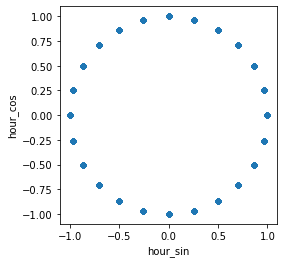

In [53]:
# convert temporal start_hour through sine & cosine transform to cyclical features
# effect: receive a two-dimensional discrete value for the time that connects subsequent cyclical hour values over days

# transform start_hour values that range from 0 to 23
data['hour_sin'] = np.sin(data['start_hour']*(2.*np.pi/24))
data['hour_cos'] = np.cos(data['start_hour']*(2.*np.pi/24))

# visualize the cyclical time feature
data.plot.scatter('hour_sin','hour_cos').set_aspect('equal');

In [54]:
# scaling the whole data to align and standardize the scales of the different features
scaler = StandardScaler()
scaler.fit(data)

data_scaled = scaler.transform(data)
data_scaled_df = pd.DataFrame(data_scaled, columns = data.columns, index = data.index)

# drop unnecessary column start_hour after scaling, because it was substituted by sin & cos values
data_scaled_df = data_scaled_df.drop(['start_hour'], axis = 1)

In [55]:
data_scaled_df.head()

,month,weekday,user_type,duration,hour_sin,hour_cos
0,-2.594193,1.649883,-0.432816,-0.517730,0.315345,2.539249
1,-2.594193,1.649883,-0.432816,-0.005594,0.315345,2.539249
2,-2.594193,1.649883,2.310449,0.736054,0.315345,2.539249
3,-2.594193,1.649883,-0.432816,-0.141216,0.315345,2.539249
4,-2.594193,1.649883,-0.432816,-0.260714,0.315345,2.539249


In [56]:
# create a separate dataframe to join trips and weather data 
df_Trips_2 = df_Trips.copy()
df_Trips_2['start_date'] = df_Trips_2['start_time']
df_Trips_2.set_index('start_date', inplace = True)
df_Trips_2.index = pd.to_datetime(df_Trips_2.index)

# get hourly demand
df_Trips_group = df_Trips_2.groupby(pd.Grouper(key='start_time', freq='H')).count()
hourly_demand = df_Trips_group['end_time']

In [57]:
# join weather and grouped trips and enhance the data set
df_grouped = df_weather
df_grouped["hourly_demand"] = hourly_demand
df_grouped["hour"] = df_grouped.index.hour
df_grouped["weekday"] = df_grouped.index.weekday
df_grouped["month"] = df_grouped.index.month
df_grouped['is_workday'] = df_grouped['weekday'].apply(lambda x: 1 if x < 5 else 0)
df_grouped['quarter'] = df_grouped['month'].apply(lambda x: x // 4)

# as hour and weekday are cyclical features the sin and cos components are calculated
df_grouped['hour_sin'] = np.sin(df_grouped.hour*(2.*np.pi/24))
df_grouped['hour_cos'] = np.cos(df_grouped.hour*(2.*np.pi/24))
df_grouped['month_sin'] = np.sin((df_grouped.month-1)*(2.*np.pi/12))
df_grouped['month_cos'] = np.cos((df_grouped.month-1)*(2.*np.pi/12))

In [58]:
df_grouped.head(2)

,max_temp,min_temp,precip,hourly_demand,hour,weekday,month,is_workday,quarter,hour_sin,hour_cos,month_sin,month_cos
date_time,,,,,,,,,,,,,
2017-01-01 00:00:00,3.9,3.9,0.0,13,0,6,1,0,0,0.000000,1.000000,0.0,1.0
2017-01-01 01:00:00,4.4,4.4,0.0,7,1,6,1,0,0,0.258819,0.965926,0.0,1.0


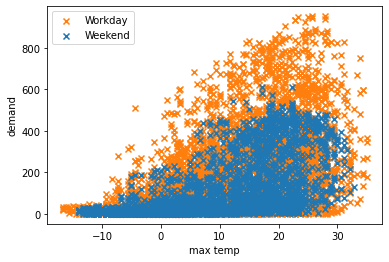

In [59]:
# visualize the grouped trips connected to the weather to get a first impression
plt.scatter(df_grouped[df_grouped["is_workday"] == 1]["max_temp"], 
            df_grouped[df_grouped["is_workday"] == 1]["hourly_demand"], marker='x', color='C1')
plt.scatter(df_grouped[df_grouped["is_workday"] == 0]["max_temp"], 
            df_grouped[df_grouped["is_workday"] == 0]["hourly_demand"], marker='x', color='C0')
plt.xlabel("max temp")
plt.ylabel("demand")
plt.legend(["Workday", "Weekend"])
plt.show()

## 3.3 Cluster Construction 

As the data is now prepared three clustering approaches are performed.  

### 3.3.1 Customer - Trips Clustering

In the first step, we are going to perform a mainly temporal clustering approach on all trips in the data set.
For that purpose we will consider all time references of each trip (month, weekday, start_hour), as well as the duration of the trip and the user type, to distinguish certain clusters of trip types and users.

First of all, we start with a grid search for an optimum k-value (number of clusters, needed as input parameter for the clustering algorithms) based on the intertia of k-means algorithm to compare different numbers of  clusters. The intertia score helps to evaluate how well a clustering could be peformed on given input data, as it presents an indication for the distance of each data point in a cluster from its assigned cluster-centroid. Comparing different scores of cluster sizes, using the elbow method, and additionally bringing in some of the already gained insights from the data, we select a good fitting value for k.

After that we apply the actual k-means clustering algorithm to the data set and interpret the determined clusters through visualizations.

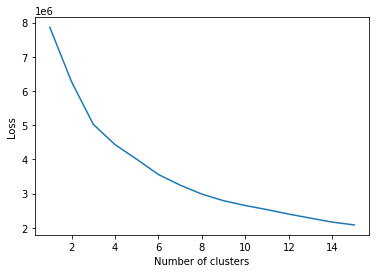

In [60]:
# grid search to determine an indication for the number of clusters as input parameter for the clustering algorithms

k_max = 15

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1)
    model.fit(data_scaled_df)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

(2.0, 10.0)

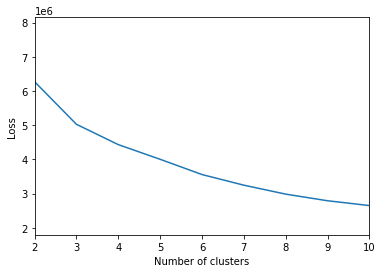

In [61]:
# zoom in the expected optimum "elbow" value area of the grid search plot

plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([2,10])

Based on the grid search, the optimum number of clusters would range from 3 to approximately 6. The clustering with the minimum value k = 3 did not achieve good clustering results. We expected at least 4-5 clusters to capture the data appropriately in clusters to distinguish between the characteristics of the descriptive analytics. So we chose 4 clusters as the next smallest number, which enabled a good fitting clustering.

In [62]:
# fit model for k = 4 and use k-means++ for initialization
model_km = KMeans(n_clusters = 4, init = 'k-means++', random_state=0)
model_km.fit(data_scaled_df)

# predict clusters and apply respective cluster name 
numbers = ['zero', 'one', 'two', 'three']
data_scaled_df['cluster'] = model_km.predict(data_scaled_df)
data_scaled_df['cluster'] = data_scaled_df['cluster'].apply(lambda x: numbers[x])

In [63]:
data_scaled_df.head()

,month,weekday,user_type,duration,hour_sin,hour_cos,cluster
0,-2.594193,1.649883,-0.432816,-0.517730,0.315345,2.539249,two
1,-2.594193,1.649883,-0.432816,-0.005594,0.315345,2.539249,two
2,-2.594193,1.649883,2.310449,0.736054,0.315345,2.539249,zero
3,-2.594193,1.649883,-0.432816,-0.141216,0.315345,2.539249,two
4,-2.594193,1.649883,-0.432816,-0.260714,0.315345,2.539249,two


In [64]:
# join required unscaled features for visualization and interpretation purposes
data_joined = data_scaled_df.join(data[['month', 'weekday', 'start_hour', 'user_type', 'duration']], lsuffix='_scaled', rsuffix='_unscaled')

# change user_type dtype to numeric for visualization
data_joined['user_type_unscaled'] = data_joined['user_type_unscaled'].apply(pd.to_numeric)

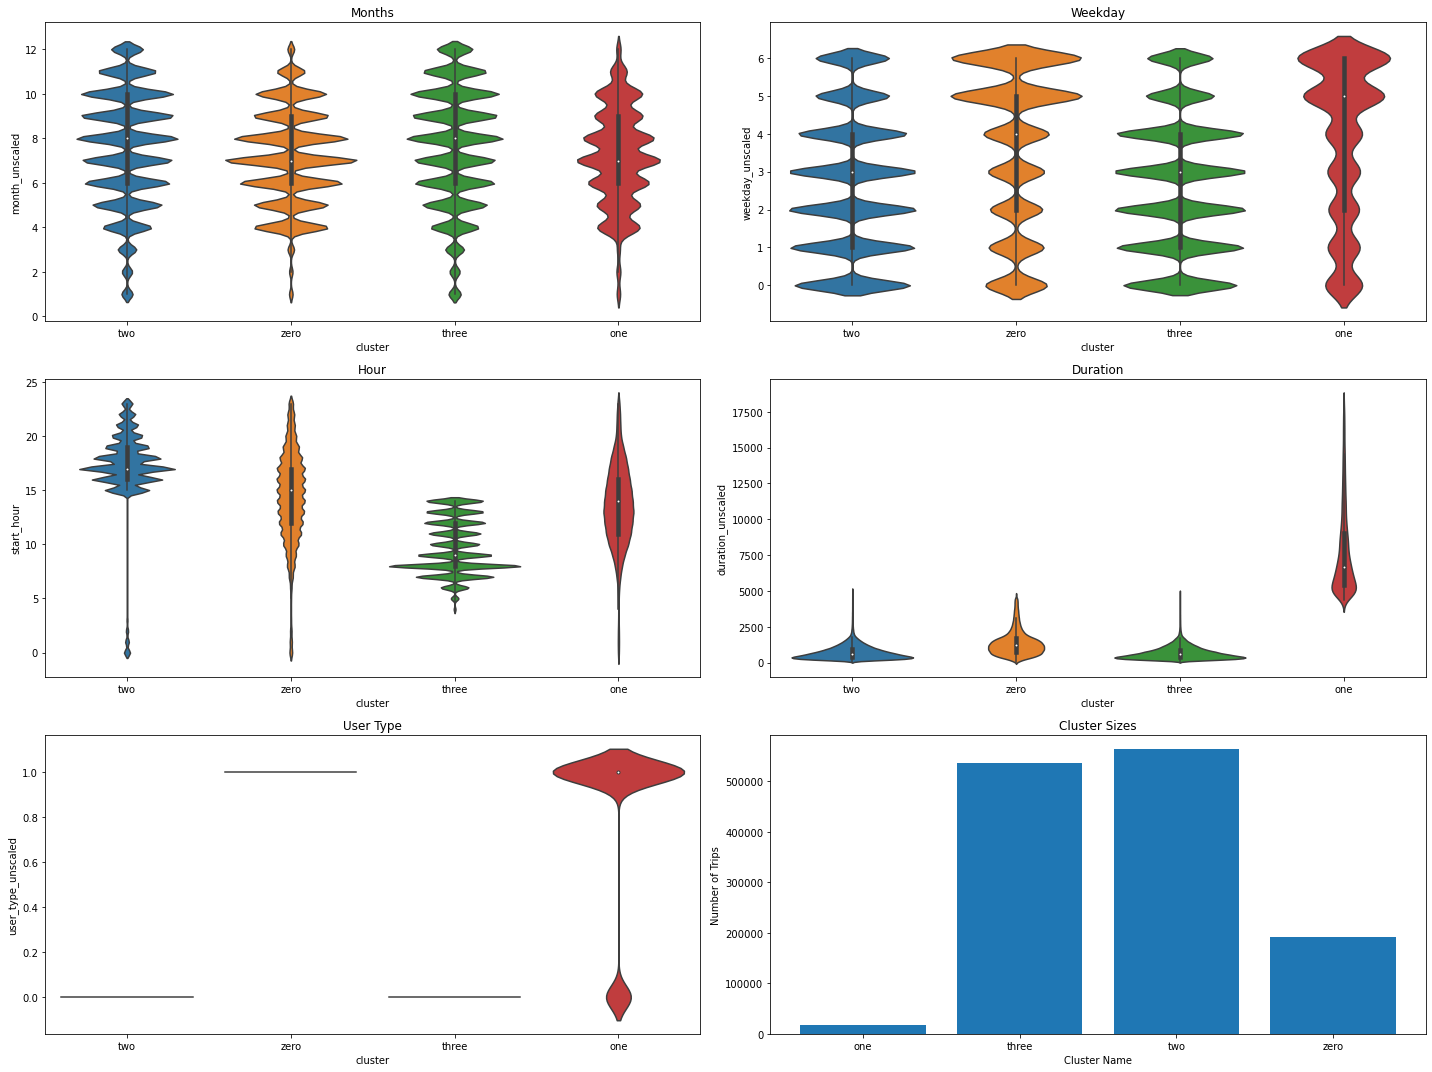

In [65]:
# create violin plots for each of the features that were included in clustering to interpret the different proposed clusters
# additionally the cluster sizes are visualized as bar plot
violin_plots, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20,15))

sns.violinplot(ax = axes[0, 0], x=data_joined['cluster'], y=data_joined['month_unscaled'], data=data_joined)
axes[0, 0].set_title('Months')

sns.violinplot(ax = axes[0, 1], x=data_joined['cluster'], y=data_joined['weekday_unscaled'], data=data_joined)
axes[0, 1].set_title('Weekday')

sns.violinplot(ax = axes[1, 0], x=data_joined['cluster'], y=data_joined['start_hour'], data=data_joined)
axes[1, 0].set_title('Hour')

sns.violinplot(ax = axes[1, 1], x=data_joined['cluster'], y=data_joined['duration_unscaled'], data=data_joined)
axes[1, 1].set_title('Duration')

sns.violinplot(ax = axes[2, 0], x=data_joined['cluster'], y=data_joined['user_type_unscaled'], data=data_joined)
axes[2, 0].set_title('User Type')

# bar plot of cluster sizes: determined  by aggregation on cluster-name
cluster_size = data_joined.groupby(['cluster'])['cluster'].agg('count')

axes[2, 1].bar(cluster_size.index, cluster_size)
axes[2, 1].set_xlabel('Cluster Name')
axes[2, 1].set_ylabel('Number of Trips')
axes[2, 1].set_title('Cluster Sizes')

violin_plots.tight_layout()
plt.show()

To interpret the value range and density for each of the involved attributes, we decided to visualize the clusters using violin plots. In combination with the bar plot displaying the sizes of the clusters, we can now describe the 4 clusters which were derived using the k-means algorithm:

- **Cluster zero** = customer cluster: contains only customer users. The customers preferably took trips from spring to autumn with a clear peak in the summer. Most trips were made on weekends between morning and 8 pm, with a peak around midday and afternoon. The duration of these trips ranged from a few short trips to a larger number of medium-short trips compared to the other clusters, suggesting that these customers make longer or slower trips (probably for tourists/sightseeing or recreational activities on the weekend)
- **Cluster one** = long trips: consists of some subscriber, but mostly customer users. This cluster mainly contains trips of the summer months. Furthermore, most of the trips were taken around noon and afternoon on weekends. The main characteristic of the clustered trips is the long duration. (which are likely carried out in free-time or for touristic purposes)
- **Cluster zero and one** includes only very few trips, which is due to the overall low number of customer trip and long trips in general
- **Cluster two and three** are quite similar: they both contain the very most of all trips which are carried out by subscribers exclusively. They also show a higher demand in spring, summer,and autumn, but compared to the other cluster they have a more even distribution over the year (=also some usages in winter). This indicates are more regular and constant demand in these clusters, which in combination with the subscriber user type could be applied to the working/ studying group of people. Also, the demand in these clusters is higher during the week than on weekends, which also supports the working/ studying assumption. The trips were very short compared to the other clusters, so that they were likely used for a specific purpose like to get quickly from A to B (within the city center).
- **Cluster two** = night trips and afternoon office hours peak: the distinction of cluster two from three is based on the start hours. This cluster includes all the few short subscriber trips during the night and late evening, as well as the peak hour trips in the afternoon that are probably taken after work/ studying/ school to get from the center to somewhere else
- **Cluster three** = morning office hours and lunchtime: this cluster contains all the subscriber trips of the morning peak, especially around 9/ 10 o'clock. Besides that, also trips around lunch time are included. So probably this cluster contains all journeys made to travel to work/university, and also between the central places

These clusters also fit the findings and expectations from the descriptive analytics very well. Therefore we assess these clusters as appropriate and k = 4 as a good value for this clustering problem. In general, it has to be mentioned that clusters zero and one have only a few trips compared
to the other two clusters. Especially the clusters two and three could be joined, since they
are quite similar except the fact that they have different time peaks, but a better fitting clustering couldn't be reached based on this data.

This clustering result offers joint insights into the different usage patterns and customer types with their characteristics. It can be used to expand or adapt the offered services. In the following sections, we provide more specific clustering use-cases that investigate the clustering problem from other angles and approaches.

### 3.3.2 Station Clustering

In this section we perform a clustering of the stations. The aim is to analyse whether the stations can be divided into clusters based on the commuter flows between home and work. The appropiate number of clusters is calculated using the grid search method. Aterwards the K-Means algorithm is used to determine the exact clusters.

In [25]:
# add a column named start_weekday to the trips dataframe that says if the start_day is a weekday or a weekend.
weekday_lst = [0, 1, 2, 3, 4]
df_Trips['start_weekday'] = ['weekday' if x in weekday_lst else 'weekend' for x in df_Trips['weekday']]

# as the aim is to group stations based on commuter flows between home and work, weekend trips are excluded. 
# create data_weekday dataframe with only the weekdays by removing all weekend days
data_weekday = df_Trips[~df_Trips.start_weekday.str.contains("weekend")]
data_weekday.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,start_hour,weekday,month,duration,start_weekday
481,2017-01-02 00:01:29,2017-01-02 00:10:30,177,74,University Park,Harvard Square at Mass Ave/ Dunster,1879,Subscriber,0,0,1,541.0,weekday
482,2017-01-02 00:06:28,2017-01-02 00:09:24,95,78,Cambridge St - at Columbia St / Webster Ave,Union Square - Somerville,901,Subscriber,0,0,1,176.0,weekday
483,2017-01-02 00:08:11,2017-01-02 00:12:12,19,33,Buswell St. at Park Dr.,Kenmore Sq / Comm Ave,17,Subscriber,0,0,1,241.0,weekday
484,2017-01-02 00:08:44,2017-01-02 00:12:06,19,33,Buswell St. at Park Dr.,Kenmore Sq / Comm Ave,103,Subscriber,0,0,1,202.0,weekday
485,2017-01-02 00:17:24,2017-01-02 00:50:12,36,20,Boston Public Library - 700 Boylston St.,Aquarium Station - 200 Atlantic Ave.,1062,Subscriber,0,0,1,1968.0,weekday


In [26]:
# group by start_hour and start_station_id and count the number of trips
data_station = data_weekday.groupby(["start_hour","start_station_id"]).count()

# use unstack() in order to be able to plot the total number of trips by hour as a function of the day for two years
data_station = data_station['duration'].unstack()
# fill all NaN with 0 
data_station = data_station.fillna(0)

data_station

start_station_id,1,3,4,5,6,7,8,9,10,11,...,221,222,224,225,226,227,228,229,230,232
start_hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,19.0,72.0,58.0,36.0,20.0,26.0,37.0,60.0,39.0,...,32.0,1.0,2.0,4.0,17.0,33.0,3.0,0.0,0.0,0.0
1,0.0,4.0,30.0,21.0,21.0,3.0,13.0,18.0,32.0,21.0,...,14.0,0.0,1.0,7.0,8.0,15.0,2.0,0.0,0.0,0.0
2,0.0,0.0,18.0,10.0,5.0,0.0,8.0,12.0,14.0,9.0,...,4.0,1.0,3.0,4.0,6.0,10.0,0.0,0.0,0.0,0.0
3,0.0,5.0,3.0,4.0,5.0,0.0,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0
4,0.0,4.0,5.0,5.0,11.0,0.0,11.0,9.0,18.0,6.0,...,1.0,0.0,0.0,3.0,4.0,6.0,0.0,0.0,0.0,0.0
5,0.0,1.0,161.0,13.0,186.0,1.0,37.0,23.0,36.0,26.0,...,9.0,0.0,4.0,12.0,4.0,5.0,1.0,0.0,0.0,0.0
6,0.0,33.0,336.0,96.0,302.0,8.0,70.0,45.0,19.0,39.0,...,23.0,11.0,10.0,54.0,36.0,43.0,3.0,0.0,0.0,0.0
7,0.0,108.0,907.0,389.0,515.0,29.0,274.0,317.0,93.0,149.0,...,119.0,49.0,29.0,172.0,167.0,134.0,2.0,0.0,0.0,0.0
8,0.0,232.0,942.0,611.0,1049.0,92.0,696.0,715.0,318.0,426.0,...,201.0,91.0,62.0,354.0,487.0,293.0,45.0,0.0,0.0,0.0


In [27]:
# scaling
scaler = StandardScaler()
scaler.fit(data_station)

data_station_scaled = scaler.transform(data_station)
data_station_scaled = pd.DataFrame(data_station_scaled, columns = data_station.columns, index = data_station.index)

data_station_scaled.head()

start_station_id,1,3,4,5,6,7,8,9,10,11,...,221,222,224,225,226,227,228,229,230,232
start_hour,,,,,,,,,,,,,,,,,,,,,
0,-0.572994,-0.778077,-0.856080,-0.998360,-1.151841,-0.586441,-0.717615,-1.131540,-0.968578,-0.829284,...,-0.926435,-0.589356,-1.134794,-1.022816,-0.745648,-0.967193,-0.600395,-0.284747,-0.284747,-0.377964
1,-0.572994,-0.866859,-1.036684,-1.204773,-1.202902,-0.662279,-0.805348,-1.224109,-1.086813,-0.893155,...,-1.233353,-0.640605,-1.185796,-0.989688,-0.830595,-1.077322,-0.612225,-0.284747,-0.284747,-0.377964
2,-0.572994,-0.890534,-1.088286,-1.266139,-1.257367,-0.675662,-0.839092,-1.253342,-1.162822,-0.935735,...,-1.403862,-0.589356,-1.083792,-1.022816,-0.849473,-1.107913,-0.635886,-0.284747,-0.284747,-0.377964
3,-0.572994,-0.860940,-1.152787,-1.299612,-1.257367,-0.675662,-0.872836,-1.302062,-1.205049,-0.953477,...,-1.472066,-0.640605,-1.236798,-1.044901,-0.858911,-1.156859,-0.635886,-0.284747,-0.284747,-0.377964
4,-0.572994,-0.866859,-1.144187,-1.294033,-1.236942,-0.675662,-0.818846,-1.267958,-1.145931,-0.946380,...,-1.455015,-0.640605,-1.236798,-1.033858,-0.868350,-1.132386,-0.635886,-0.284747,-0.284747,-0.377964


D:\Programme\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


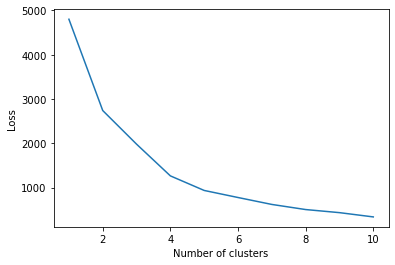

In [28]:
# grid search to determine the number of clusters as input parameter for the clustering algorithms
k_max = 10

clusters = []
losses = []

for k in range(k_max):
    model = KMeans(n_clusters = k + 1)
    model.fit(data_station_scaled)
    
    clusters.append(k+1)
    losses.append(model.inertia_)
    
# Plot grid search result
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

The result of the grid search sow that between 2 and 4 clusters are appropiate for our task. 

Through testing and domain knowledge, we have concluded that a clustering with 3 clusters will lead to the most insightful outcome.

In [29]:
# transpose the dataframe in order to be able to apply the k-means model on each bike station.
data_station_scaled_trans = data_station_scaled.transpose()

# transform the trips_station_normal_trans dataframe to an array in order to be able to use k-means method
X = data_station_scaled_trans.to_numpy()

# fit the kmeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
data_station_scaled_trans['cluster']=kmeans.predict(data_station_scaled_trans)

In [30]:
# transpose the dataframe to have the cluster number for each station in the dataframe
data_station_scaled_cluster = data_station_scaled_trans.transpose()
data_station_scaled_cluster.tail()

start_station_id,1,3,4,5,6,7,8,9,10,11,...,221,222,224,225,226,227,228,229,230,232
start_hour,,,,,,,,,,,,,,,,,,,,,
20,-0.572994,-0.055982,-0.176663,0.731046,-0.181691,-0.140337,-0.292445,0.344699,0.382681,-0.190577,...,0.028418,0.025624,0.395265,-0.117327,0.103824,0.060673,-0.316464,-0.284747,-0.284747,2.645751
21,-0.572994,-0.316410,-0.258365,0.318220,-0.552731,-0.345545,-0.434168,0.047503,-0.111373,-0.421221,...,0.710457,-0.435611,-0.624774,-0.437561,-0.028316,-0.379841,-0.434769,-0.284747,-0.284747,-0.377964
22,-0.572994,-0.422948,-0.383068,-0.440487,-0.627620,-0.465993,-0.488158,-0.517658,-0.419629,-0.502834,...,-0.107989,-0.589356,-1.236798,-0.536944,-0.320912,-0.502206,-0.505751,-0.284747,-0.284747,-0.377964
23,-0.572994,-0.618269,-0.589473,-0.685951,-0.852286,-0.515064,-0.616384,-0.741774,-0.698326,-0.598640,...,-0.380805,-0.384363,-1.134794,-0.757795,-0.519122,-0.691872,-0.493921,-0.284747,-0.284747,-0.377964
cluster,1.000000,1.000000,0.000000,2.000000,2.000000,1.000000,0.000000,2.000000,1.000000,1.000000,...,2.000000,0.000000,2.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [31]:
# select the stations that are part of cluster 0 (i.e. that have index 24 = 0)
data_station_scaled_cluster0 = data_station_scaled_cluster[data_station_scaled_cluster.columns[data_station_scaled_cluster.iloc[-1]==0.000000]]

# select the stations that are part of cluster 1 (i.e. that have index 24 = 1)
data_station_scaled_cluster1 = data_station_scaled_cluster[data_station_scaled_cluster.columns[data_station_scaled_cluster.iloc[-1]==1.000000]]

# select the stations that are part of cluster 2 (i.e. that have index 24 = 2)
data_station_scaled_cluster2 = data_station_scaled_cluster[data_station_scaled_cluster.columns[data_station_scaled_cluster.iloc[-1]==2.000000]]

In [32]:
# remove the last row of the previous dataframe
data_station_scaled_cluster0 = data_station_scaled_cluster0.drop(['cluster'])

# remove the last row of the previous dataframe
data_station_scaled_cluster1 = data_station_scaled_cluster1.drop(['cluster'])

# remove the last row of the previous dataframe
data_station_scaled_cluster2 = data_station_scaled_cluster2.drop(['cluster'])

In [33]:
# add a column that gives the average of all previous columns
data_station_scaled_cluster0['average'] = data_station_scaled_cluster0.mean(numeric_only=True, axis=1)

# add a column that gives the average of all previous columns
data_station_scaled_cluster1['average'] = data_station_scaled_cluster1.mean(numeric_only=True, axis=1)

# add a column that gives the average of all previous columns
data_station_scaled_cluster2['average'] = data_station_scaled_cluster2.mean(numeric_only=True, axis=1)

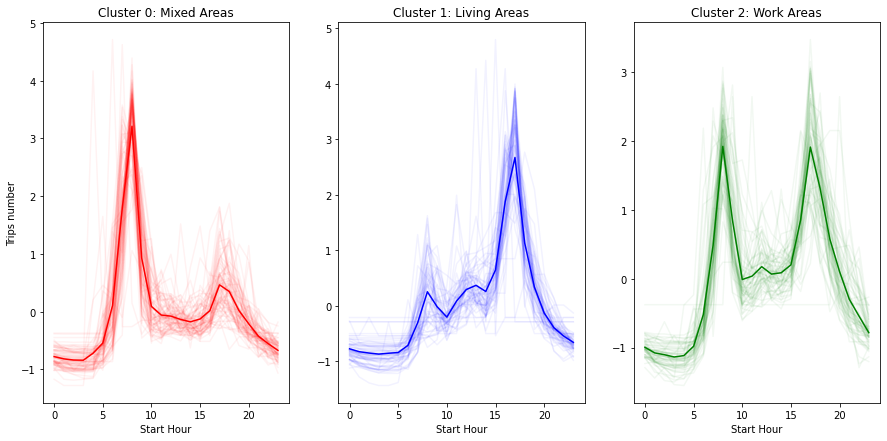

In [34]:
# plot all the normalised curves and the average for each cluster
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(15,7))

# plot cluster 0
data_station_scaled_cluster0.plot(ax=ax[0],color='red', alpha=0.05)
data_station_scaled_cluster0["average"].plot(ax=ax[0],color='red', alpha=1)
ax[0].get_legend().remove()
ax[0].set_title('Cluster 0: Mixed Areas')
ax[0].set_ylabel('Trips number')
ax[0].set_xlabel('Start Hour')

# plot cluster 1 
data_station_scaled_cluster1.plot(ax=ax[1],color='blue', alpha=0.05)
data_station_scaled_cluster1["average"].plot(ax=ax[1],color='blue', alpha=1)
ax[1].get_legend().remove()
ax[1].set_title('Cluster 1: Living Areas')
ax[1].set_xlabel('Start Hour')

# plot cluster 2
data_station_scaled_cluster2.plot(ax=ax[2],color='green', alpha=0.05)
data_station_scaled_cluster2["average"].plot(ax=ax[2],color='green', alpha=1)
ax[2].get_legend().remove()
ax[2].set_title('Cluster 2: Work Areas')
ax[2].set_xlabel('Start Hour')

plt.show()

The plot shows the number of trips and the respective starting hour. 
Each cluster has one or more peaks that allow conclusions to be drawn about the environment of the stations in each cluster. 

- **Cluster zero:** stations located in mixed areas 
    - peak at 8 AM 
    - peak at 5 PM 
- **Cluster one:** stations located in living areas
    - peak at 8 AM
- **Cluster two:** stations located in work areas 
    - peak at 5 PM

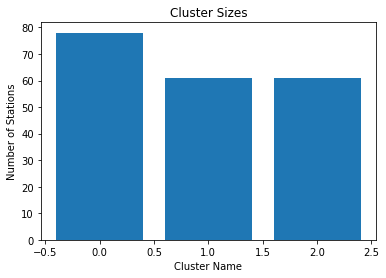

In [35]:
trips_station_scaled_cluster_trans = data_station_scaled_cluster.transpose()

# determine cluster sizes by aggregating on cluster-name through counting
cluster_size = trips_station_scaled_cluster_trans.groupby(['cluster'])['cluster'].agg('count')

# plot the cluster sizes as bar chart
plt.bar(cluster_size.index, cluster_size)
plt.xlabel('Cluster Name')
plt.ylabel('Number of Stations')
plt.title('Cluster Sizes')

plt.show()

In [36]:
#station clustering output 
clusterString = ['zero', 'one', 'two']
output = data_station_scaled_trans['cluster'].copy()
outputDataframe = pd.DataFrame(output)
outputDataframe['cluster'] = outputDataframe['cluster'].apply(lambda x: clusterString[x])
outputDataframe.to_csv('station_clustering.csv')
outputDataframe.head()

,cluster
start_station_id,
1,one
3,one
4,zero
5,two
6,two


In [46]:
IFrame(src='./visualization files/cluster_map.html', width=500, height=400)
# red = cluster zero : mixed areas
# blue = cluster one : living areas
# green = cluster two : work areas

The map displays the distribution of the stations allocated to the clusters. The map shows the distribution of the stations assigned to the clusters. The increased distribution of green stations in the city center and harbor area supports the work area theory. The red stations show the transition to the residential area. The blue stations mark the commuter belt of the city and are increasingly found away from the city center.

### 3.3.1 Weather - Trip Clustering

Finally we want to find out if the weather has an impact on the trips. Hence we perform a clustering of all hourly grouped trips in connection to the weather data. 

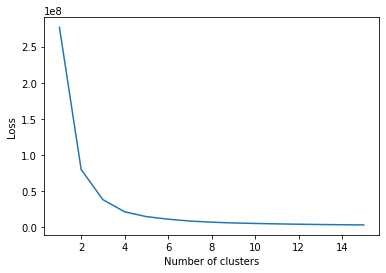

In [38]:
# grid search to determine an indication for the number of clusters as input parameter for the clustering algorithms
w_k_max = 15

w_clusters = []
w_losses = []

for k in range(w_k_max):
    w_model = KMeans(n_clusters = k + 1)
    w_model.fit(df_grouped)
    
    w_clusters.append(k+1)
    w_losses.append(w_model.inertia_)
    
# plot grid search result
plt.plot(w_clusters, w_losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

In [39]:
# save clusters into new dataframe, so the previous one stays unchanged
df_clustered = df_grouped.copy()

# fit model for optimal k-value
w_model_fit = KMeans(n_clusters = 3)
w_model_fit.fit(df_clustered)

# add clusters to new dataset
numbers = ['zero', 'one', 'two']
df_clustered['cluster'] = w_model_fit.predict(df_clustered)
df_clustered['cluster'] = df_clustered['cluster'].apply(lambda x: numbers[x])

df_clustered.head(2)

,max_temp,min_temp,precip,hourly_demand,hour,weekday,month,is_workday,quarter,hour_sin,hour_cos,month_sin,month_cos,cluster
date_time,,,,,,,,,,,,,,
2017-01-01 00:00:00,3.9,3.9,0.0,13,0,6,1,0,0,0.000000,1.000000,0.0,1.0,zero
2017-01-01 01:00:00,4.4,4.4,0.0,7,1,6,1,0,0,0.258819,0.965926,0.0,1.0,zero


In [40]:
# write a function to create a 3d plot
def plot_3d_scatter(dataset, title):
    cluster = ['zero', 'one', 'two']
    colors = ['C0', 'C1', 'C2']
    marker = ['.', 'o', 'x']

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i in range (0, len(cluster)): 
        x = dataset[dataset["cluster"] == cluster[i]]["max_temp"]
        y = dataset[dataset["cluster"] == cluster[i]]["hour"]
        z = dataset[dataset["cluster"] == cluster[i]]["hourly_demand"]
        ax.scatter(x, y, z, marker= marker[i], color=colors[i])

    ax.set_xlabel('max. temperature (°C)')
    ax.set_ylabel('starting hour')
    ax.set_zlabel('bike demand');
    plt.title(title)
    plt.legend(["zero", "one", "two"])
    fig.set_size_inches(6, 6)
    plt.show()

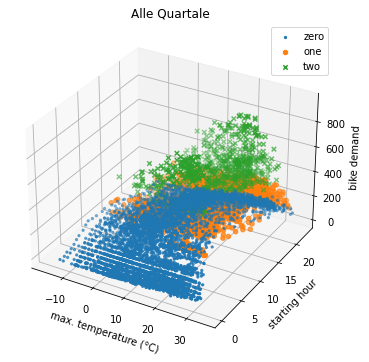

In [41]:
plot_3d_scatter(df_clustered, 'Alle Quartale')

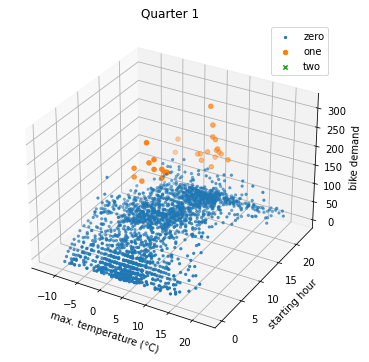

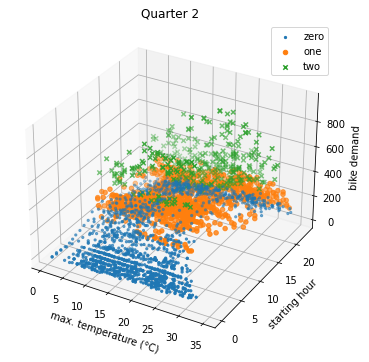

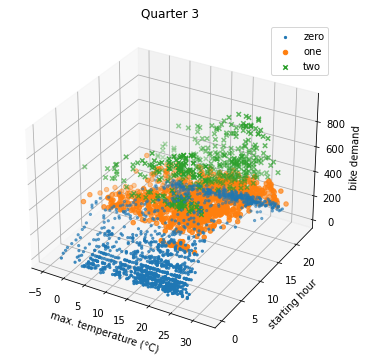

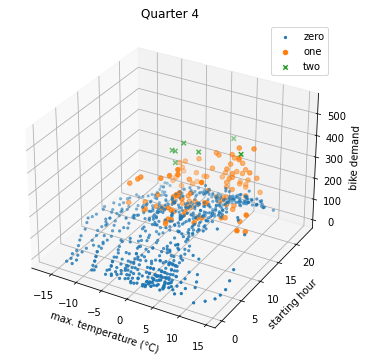

In [42]:
df_clustered_q1 = df_clustered[df_clustered["quarter"] == 0].copy()
df_clustered_q2 = df_clustered[df_clustered["quarter"] == 1].copy()
df_clustered_q3 = df_clustered[df_clustered["quarter"] == 2].copy()
df_clustered_q4 = df_clustered[df_clustered["quarter"] == 3].copy()

plot_3d_scatter(df_clustered_q1, 'Quarter 1')
plot_3d_scatter(df_clustered_q2, 'Quarter 2')
plot_3d_scatter(df_clustered_q3, 'Quarter 3')
plot_3d_scatter(df_clustered_q4, 'Quarter 4')

In [43]:
df_describe_cl = df_clustered[df_clustered["cluster"] == 'zero']
df_describe_cl.describe()

,max_temp,min_temp,precip,hourly_demand,hour,weekday,month,is_workday,quarter,hour_sin,hour_cos,month_sin,month_cos
count,5714.000000,5714.000000,5714.000000,5714.000000,5714.000000,5714.000000,5714.000000,5714.000000,5714.000000,5714.000000,5714.000000,5.714000e+03,5714.000000
mean,8.130387,8.075750,0.122798,43.167133,10.286139,3.114806,5.903745,0.681134,1.098530,0.126857,0.239539,7.879016e-02,0.215072
std,9.565216,9.560381,0.321710,43.163206,7.747494,2.040663,3.789283,0.466078,1.027159,0.672686,0.688611,6.885485e-01,0.688188
min,-16.700000,-16.700000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000
25%,1.100000,1.100000,0.000000,8.000000,3.000000,1.000000,3.000000,0.000000,0.000000,-0.500000,-0.258819,-5.000000e-01,-0.500000
50%,7.200000,6.950000,0.000000,28.000000,8.000000,3.000000,5.000000,1.000000,1.000000,0.258819,0.500000,1.224647e-16,0.500000
75%,15.600000,15.600000,0.000000,67.000000,18.000000,5.000000,10.000000,1.000000,2.000000,0.707107,0.866025,8.660254e-01,0.866025
max,34.400000,34.400000,1.000000,159.000000,23.000000,6.000000,12.000000,1.000000,3.000000,1.000000,1.000000,1.000000e+00,1.000000


In [44]:
df_describe_cl = df_clustered[df_clustered["cluster"] == 'one']
df_describe_cl.describe()

,max_temp,min_temp,precip,hourly_demand,hour,weekday,month,is_workday,quarter,hour_sin,hour_cos,month_sin,month_cos
count,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2305.000000,2.305000e+03,2305.000000,2.305000e+03
mean,16.686016,16.642458,0.046565,275.133189,13.757484,2.878091,7.671150,0.753579,1.549675,-0.208169,-4.699685e-01,-0.131167,-3.834729e-01
std,7.554790,7.552061,0.204775,75.263415,4.148577,1.938815,2.369761,0.431020,0.604728,0.667977,5.384434e-01,0.726660,5.550418e-01
min,-8.300000,-8.300000,0.000000,159.000000,6.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000e+00
25%,11.700000,11.700000,0.000000,210.000000,10.000000,1.000000,6.000000,1.000000,1.000000,-0.866025,-8.660254e-01,-0.866025,-8.660254e-01
50%,17.800000,17.800000,0.000000,268.000000,13.000000,3.000000,8.000000,1.000000,2.000000,-0.258819,-7.071068e-01,-0.500000,-5.000000e-01
75%,22.200000,22.200000,0.000000,337.000000,18.000000,4.000000,10.000000,1.000000,2.000000,0.500000,-1.836970e-16,0.500000,-1.836970e-16
max,35.000000,35.000000,1.000000,427.000000,22.000000,6.000000,12.000000,1.000000,3.000000,1.000000,8.660254e-01,1.000000,1.000000e+00


In [45]:
df_describe_cl = df_clustered[df_clustered["cluster"] == 'two']
df_describe_cl.describe()

,max_temp,min_temp,precip,hourly_demand,hour,weekday,month,is_workday,quarter,hour_sin,hour_cos,month_sin,month_cos
count,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,7.410000e+02
mean,19.714845,19.675506,0.024966,580.190283,13.838057,2.591093,7.762483,0.824561,1.574899,-0.330677,-0.385218,-0.240619,-5.217109e-01
std,6.409099,6.402137,0.152847,129.584868,4.185652,1.828861,1.944569,0.380599,0.516083,0.816996,0.275281,0.674685,4.643551e-01
min,-4.400000,-4.400000,0.000000,428.000000,7.000000,0.000000,4.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00
25%,16.100000,16.100000,0.000000,467.000000,8.000000,1.000000,6.000000,1.000000,1.000000,-0.965926,-0.500000,-0.866025,-8.660254e-01
50%,20.000000,20.000000,0.000000,550.000000,16.000000,2.000000,8.000000,1.000000,2.000000,-0.866025,-0.500000,-0.500000,-5.000000e-01
75%,24.400000,24.400000,0.000000,666.000000,17.000000,4.000000,9.000000,1.000000,2.000000,0.866025,-0.258819,0.500000,-1.836970e-16
max,34.400000,34.400000,1.000000,952.000000,23.000000,6.000000,12.000000,1.000000,3.000000,0.965926,0.965926,1.000000,8.660254e-01


The 5 plots offer a good possibility to interpret the assigned clusters.
The following clusters emerged from the k-means algorithm:

- **Cluster zero: All-Weather-Trips** = contains the consistent but relavtively low demand of bikes during the whole day and over the whole year.
    - there is a constant demand at temperatures from -15 degrees to 35 degrees
    - the total hourly demand of bikes goes up to 159 bikes
    - those trips are spread over the whole day

- **Cluster one: Summer-Evening-Trips** = contains the high demand hours of bikes during the summer month, which reach into the late evening and only take place during quarter 2 and 3 of the year.
    - there is only a demand at temperatures from -4 degrees to 34 degrees
    - the total hourly demand of bikes is between 159 and 427 bikes
    - those trips do not start before 7:00 AM but reach into the late evening (11:00 PM) 

- **Cluster two: Middle-Trips** = contains rather the average demand of bikes based on the weather and start time during the warmer month of the year
    - there is only a demand at temperatures from -8 degrees to 35 degrees
    - the total hourly demand of bikes lies between 428 and 952 bikes
    - those trips don't start before 6:00 AM but end already at 10:00 PM
